# Library

In [1]:
import cv2
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from skimage import exposure, feature
from skimage.feature import hog
from imutils import paths
import matplotlib.pyplot as plt
import argparse
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, log_loss
import seaborn as sns
import pandas as pd
import random
import shutil
import time

# Local Binary Pattern Setup

In [2]:
# Local Binnary Patterns (LBP) class
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        self.numPoints = numPoints
        self.radius = radius

    def describe(self, image, eps=1e-7):
        lbp = feature.local_binary_pattern(image, self.numPoints,
                                           self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
                                  bins=np.arange(0, self.numPoints + 3),
                                  range=(0, self.numPoints + 2))

        # Normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)

        return hist

In [3]:
# Initialize the local binary patterns descriptor along with
desc = LocalBinaryPatterns(8, 1)

# Histogram Oriented Gradient Setup

In [4]:
# HOG parameters
hog_params = {
    'orientations': 9, # number of bins
    'pixels_per_cell': (8, 8), # pixel size
    'cells_per_block': (2, 2), # number of cells
    'block_norm': 'L2-Hys' # block norm
}

# Dataset

In [5]:
# Specify the paths to the training and testing images
training_path = "Dataset/Train"
testing_path = "Dataset/Test"

## Training Data Feature Extraction

In [6]:
# Initialize the data and label lists
data = []
labels = []

In [7]:
# Add time measurement
start = time.time()

# Loop over the training images
training_path = "Dataset/Train"
for imagePath in paths.list_images(training_path):
    # Load the image, convert it to grayscale, and describe it
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Extract LBP features
    lbp_hist = desc.describe(gray)
    
    # Extract HOG features
    hog_features = hog(gray, **hog_params)
    
    # Combine HOG and LBP features
    features = np.hstack((hog_features, lbp_hist))
    
    # Extract the label from the image path, then update the labels and data
    labels.append(imagePath.split(os.path.sep)[-2])
    data.append(features)

# Stop time measurement
end = time.time()

# Calculate the elapsed time
elapsed_time = end - start
print(f"Time taken to process the training images: {elapsed_time:.2f} seconds")

Time taken to process the training images: 802.89 seconds


In [8]:
# Convert data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

In [9]:
# Check the length of the data and labels
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

# check the number of unique labels
unique_labels = np.unique(labels)

# check the lengt of each unique label
for label in unique_labels:
    print(f"Number of images with label {label}: {len(data[labels == label])}")

Data shape: (32000, 26254)
Labels shape: (32000,)
Number of images with label Negative: 16000
Number of images with label Positive: 16000


# Modelling

## Training Model Random Forest Gini Criterion

In [10]:
# Add time measurement
start = time.time()
# Train a Random Forest Gini Criterion
model_RFG = RandomForestClassifier(criterion='gini',random_state=42)
model_RFG.fit(data,labels)
# Stop time measurement
end = time.time()

# Calculate the elapsed time
elapsed_time = end - start
print(f"Time taken to train the Random Forest Gini Criterion: {elapsed_time:.2f} seconds")

Time taken to train the Random Forest Gini Criterion: 1375.83 seconds


## Training Model Random Forest Entropy Criterion

In [11]:
# Add time measurement
start = time.time()
# Train a Random Forest Information Gain Criterion
model_RFE = RandomForestClassifier(criterion='entropy',random_state=42)
model_RFE.fit(data,labels)
# Stop time measurement
end = time.time()

# Calculate the elapsed time
elapsed_time = end - start
print(f"Time taken to train the Random Forest Information Gain Criterion: {elapsed_time:.2f} seconds")

Time taken to train the Random Forest Information Gain Criterion: 1065.25 seconds


## Training Model Random Forest Log Loss Criterion

In [12]:
# Add time measurement
start = time.time()
# Train a Random Forest Information Gain Criterion
model_RFL = RandomForestClassifier(criterion='log_loss',random_state=42)
model_RFL.fit(data,labels)
# Stop time measurement
end = time.time()

# Calculate the elapsed time
elapsed_time = end - start
print(f"Time taken to train the Random Forest Log Loss Criterion: {elapsed_time:.2f} seconds")


Time taken to train the Random Forest Log Loss Criterion: 1058.59 seconds


# Confussion Matrix & Classification Report Random Forest Gini

In [13]:
# Initialize empty lists for true labels and predicted labels
true_labels = []
predicted_labels = []

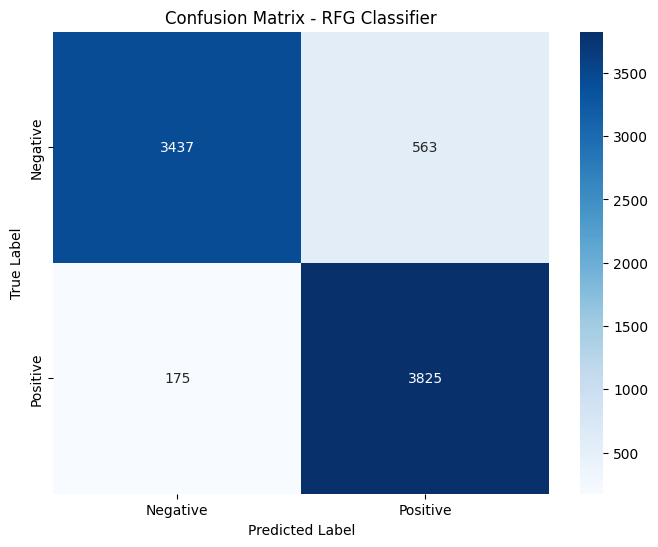

Time taken to predict the testing images: 248.63 seconds


In [17]:
# Add time measurement
start = time.time()
# Loop over the testing images
for imagePath in paths.list_images(testing_path):
    # Load the image, convert it to grayscale, describe it
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Extract LBP features
    lbp_hist = desc.describe(gray)
    
    # Extract HOG features
    hog_features = hog(gray, **hog_params)
    
    # Combine HOG and LBP features
    features = np.hstack((hog_features, lbp_hist))
    
    # Predict the label using the trained SVM classifier
    prediction = model_RFG.predict(features.reshape(1, -1))
    
    # Extract the true label from the image path
    true_label = imagePath.split(os.path.sep)[-2]
    
    # Update the lists
    true_labels.append(true_label)
    predicted_labels.append(prediction[0])

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels),
            yticklabels=np.unique(true_labels))
plt.title('Confusion Matrix - RFG Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Stop time measurement
end = time.time()

# Calculate the elapsed time
elapsed_time = end - start
print(f"Time taken to predict the testing images: {elapsed_time:.2f} seconds")

In [15]:
# Get the classification report
class_report = classification_report(true_labels, predicted_labels, digits=4)
print("Classification Report:\n", class_report)

# Get the accuracy score
acc_score_RFG_n8r1 = accuracy_score(true_labels, predicted_labels)
print("Accuracy Score:", acc_score_RFG_n8r1)

# Get the F1 score
f1_score_RFG_n8r1 = f1_score(true_labels, predicted_labels, average='weighted')
print("F1 Score:", f1_score_RFG_n8r1)

Classification Report:
               precision    recall  f1-score   support

    Negative     0.9516    0.8592    0.9030      4000
    Positive     0.8717    0.9563    0.9120      4000

    accuracy                         0.9077      8000
   macro avg     0.9116    0.9078    0.9075      8000
weighted avg     0.9116    0.9077    0.9075      8000

Accuracy Score: 0.90775
F1 Score: 0.9075324933073823


# Confussion Matrix & Classification Report Random Forest Entropy

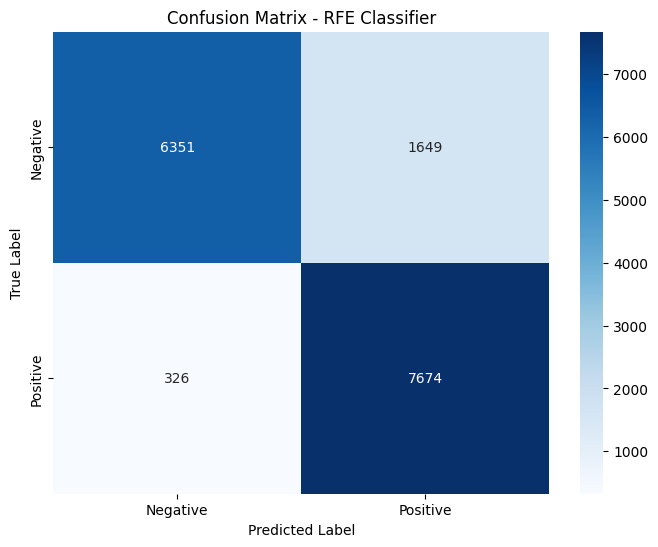

Time taken to predict the testing images: 222.82 seconds


In [18]:
# Add time measurement
start = time.time()
# Loop over the testing images
for imagePath in paths.list_images(testing_path):
    # Load the image, convert it to grayscale, describe it
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Extract LBP features
    lbp_hist = desc.describe(gray)
    
    # Extract HOG features
    hog_features = hog(gray, **hog_params)
    
    # Combine HOG and LBP features
    features = np.hstack((hog_features, lbp_hist))
    
    # Predict the label using the trained SVM classifier
    prediction = model_RFE.predict(features.reshape(1, -1))
    
    # Extract the true label from the image path
    true_label = imagePath.split(os.path.sep)[-2]
    
    # Update the lists
    true_labels.append(true_label)
    predicted_labels.append(prediction[0])

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels),
            yticklabels=np.unique(true_labels))
plt.title('Confusion Matrix - RFE Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Stop time measurement
end = time.time()

# Calculate the elapsed time
elapsed_time = end - start
print(f"Time taken to predict the testing images: {elapsed_time:.2f} seconds")

In [19]:
# Get the classification report
class_report = classification_report(true_labels, predicted_labels, digits=4)
print("Classification Report:\n", class_report)

# Get the accuracy score
acc_score_RFE_n8r1 = accuracy_score(true_labels, predicted_labels)
print("Accuracy Score:", acc_score_RFE_n8r1)

# Get the F1 score
f1_score_RFE_n8r1 = f1_score(true_labels, predicted_labels, average='weighted')
print("F1 Score:", f1_score_RFE_n8r1)

Classification Report:
               precision    recall  f1-score   support

    Negative     0.9512    0.7939    0.8654      8000
    Positive     0.8231    0.9593    0.8860      8000

    accuracy                         0.8766     16000
   macro avg     0.8872    0.8766    0.8757     16000
weighted avg     0.8872    0.8766    0.8757     16000

Accuracy Score: 0.8765625
F1 Score: 0.8757127201946312


# Confussion Matrix & Classification Report Random Forest Log Loss

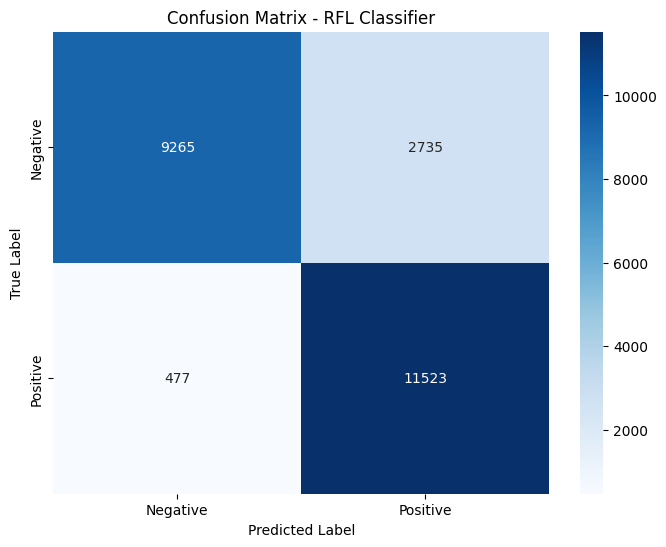

Time taken to predict the testing images: 222.69 seconds


In [20]:
# Add time measurement
start = time.time()
# Loop over the testing images
for imagePath in paths.list_images(testing_path):
    # Load the image, convert it to grayscale, describe it
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Extract LBP features
    lbp_hist = desc.describe(gray)
    
    # Extract HOG features
    hog_features = hog(gray, **hog_params)
    
    # Combine HOG and LBP features
    features = np.hstack((hog_features, lbp_hist))
    
    # Predict the label using the trained SVM classifier
    prediction = model_RFL.predict(features.reshape(1, -1))
    
    # Extract the true label from the image path
    true_label = imagePath.split(os.path.sep)[-2]
    
    # Update the lists
    true_labels.append(true_label)
    predicted_labels.append(prediction[0])

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels),
            yticklabels=np.unique(true_labels))
plt.title('Confusion Matrix - RFL Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Stop time measurement
end = time.time()

# Calculate the elapsed time
elapsed_time = end - start
print(f"Time taken to predict the testing images: {elapsed_time:.2f} seconds")

In [21]:
# Get the classification report
class_report = classification_report(true_labels, predicted_labels, digits=4)
print("Classification Report:\n", class_report)

# Get the accuracy score
acc_score_RFL_n8r1 = accuracy_score(true_labels, predicted_labels)
print("Accuracy Score:", acc_score_RFL_n8r1)

# Get the F1 score
f1_score_RFL_n8r1 = f1_score(true_labels, predicted_labels, average='weighted')
print("F1 Score:", f1_score_RFL_n8r1)

Classification Report:
               precision    recall  f1-score   support

    Negative     0.9510    0.7721    0.8523     12000
    Positive     0.8082    0.9603    0.8777     12000

    accuracy                         0.8662     24000
   macro avg     0.8796    0.8662    0.8650     24000
weighted avg     0.8796    0.8662    0.8650     24000

Accuracy Score: 0.8661666666666666
F1 Score: 0.8649714379068404


# Wrapping Up

In [22]:
# wrap the models in a list
# make dict of models to loop through
model = {
    "Random Forest Gini NumPoint = 8 Radius = 1": model_RFG,
    "Random Forest Entropy NumPoint = 8 Radius = 1": model_RFE,
    "Random Forest Log Loss NumPoint = 8 Radius = 1": model_RFL
}

# Make dict of accuracy scores to loop through
acc_score = {
    "Random Forest Gini NumPoint = 8 Radius = 1": acc_score_RFG_n8r1,
    "Random Forest Entropy NumPoint = 8 Radius = 1": acc_score_RFE_n8r1,
    "Random Forest Log Loss NumPoint = 8 Radius = 1": acc_score_RFL_n8r1
}

# Make dict of F1 scores to loop through
f1_score = {
    "Random Forest Gini NumPoint = 8 Radius = 1": f1_score_RFG_n8r1,
    "Random Forest Entropy NumPoint = 8 Radius = 1": f1_score_RFE_n8r1,
    "Random Forest Log Loss NumPoint = 8 Radius = 1": f1_score_RFL_n8r1
}

# Make DataFrame of all the scores
df = pd.DataFrame(list(acc_score.items()), columns=['Model', 'Accuracy Score'])
df['F1 Score'] = f1_score.values()

# Sort the values by f1 score
df.sort_values(by=['F1 Score'], inplace=True, ascending=False)

# Display the DataFrame
print(df)

                                            Model  Accuracy Score  F1 Score
0      Random Forest Gini NumPoint = 8 Radius = 1        0.907750  0.907532
1   Random Forest Entropy NumPoint = 8 Radius = 1        0.876563  0.875713
2  Random Forest Log Loss NumPoint = 8 Radius = 1        0.866167  0.864971


# Save Model

In [25]:
# Save all the model
import pickle
# model as a pickle file
model_RFG_pkl_file = "RFG_n8r1.pkl"
model_RFE_pkl_file = "RFE_n8r1.pkl"
model_RFL_pkl_file = "RFL_n8r1.pkl"

with open(model_RFG_pkl_file, 'wb') as file:  
    pickle.dump(model_RFG, file)

with open(model_RFE_pkl_file, 'wb') as file:
    pickle.dump(model_RFE, file)

with open(model_RFL_pkl_file, 'wb') as file:
    pickle.dump(model_RFL, file)